# CS 203 Assignment 5
Shah Harshil Hardik (23110132)<br>
Shah Tirth (23110295)<br>
Team 26

In [41]:
!pip install augly -q


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Setup

### Import the libraries

In [42]:
import os
import augly.image as imaugs
import random
from PIL import Image
import numpy as np
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from transformers import AutoImageProcessor, AutoModelForImageClassification

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [43]:
dataset_path = "dataset"

### Set device

In [44]:
if torch.backends.mps.is_available():
    device="mps"
elif torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
print(device)

mps


# Augly

### Define the augmentations

In [45]:
augmentations = [
    imaugs.Rotate(degrees=random.randint(-30, 30)),  # Rotate by random degrees
    imaugs.Sharpen(factor=1.0),
    imaugs.Blur(),  # Fixed Blur transformation
    imaugs.Resize(height=128, width=128),  # Resize to 128x128
    imaugs.HFlip(),  # Flip horizontally
    imaugs.ColorJitter(brightness_factor= 1.2, contrast_factor= 1.2, saturation_factor= 1.4),  # Adjust colors
    imaugs.OverlayText(  # Add overlay text on the image
        text=[1],
        font_size=0.5,
        color=(255, 0, 0),
        opacity=0.5,
        x_pos=0.1,
        y_pos=0.1
    ),
    imaugs.Grayscale(),  # Make grayscale
    imaugs.Pad(w_factor=0.1, h_factor=0.1),  # Add padding using width & height factors
    imaugs.Sharpen()  # Sharpen the image
]

### Function to augment the data

In [46]:
def augment_image(augmentations, img_folder_path, class_, output_folder, num_augmentations=6):
    os.makedirs(output_folder+f"/{class_}", exist_ok=True)  

    for img in os.listdir(img_folder_path):
        img_path = os.path.join(img_folder_path, img)
        image = Image.open(img_path).convert("RGB")  

        for i in range(num_augmentations):
            augmented_image_1 = image.copy()
            augmented_image_2 = image.copy()
            transforms = random.sample(augmentations, num_augmentations)

        for i in range(3):
            augmented_image_1 = transforms[i](augmented_image_1)
        for i in range(3):
            augmented_image_2 = transforms[i+3](augmented_image_2)

        # Generate a unique name for each augmented image
        aug_1_name = f"{os.path.splitext(img)[0]}_aug_1.jpg"
        aug_2_name = f"{os.path.splitext(img)[0]}_aug_2.jpg"
        augmented_image_1.save(os.path.join(output_folder + f"/{class_}", aug_1_name))
        augmented_image_2.save(os.path.join(output_folder + f"/{class_}", aug_2_name))
        image.save(os.path.join(output_folder + f"/{class_}", img))

### Augment the images

In [ ]:
classes = ["cats", "dogs"]
for class_ in classes:
  img_folder_path = os.path.join(dataset_path, "train", class_)
  output_folder = os.path.join(dataset_path, "augmented")
  augment_image(augmentations, img_folder_path, class_, output_folder=output_folder, num_augmentations=6)

In [ ]:
len_original_data = len(os.listdir(os.path.join(dataset_path + "/train/cats"))) + len(os.listdir(os.path.join(dataset_path + "/train/dogs")))
len_augmented_data = len(os.listdir(os.path.join(dataset_path + "/augmented/cats"))) + len(os.listdir(os.path.join(dataset_path + "/augmented/dogs")))
print(f"Length og Original data: {len_original_data}")
print(f"Length of Augmented data: {len_augmented_data}")

Length og Original data: 112
Length of Augmented data: 336


### Plots showing the counts of training, testing and augmented data

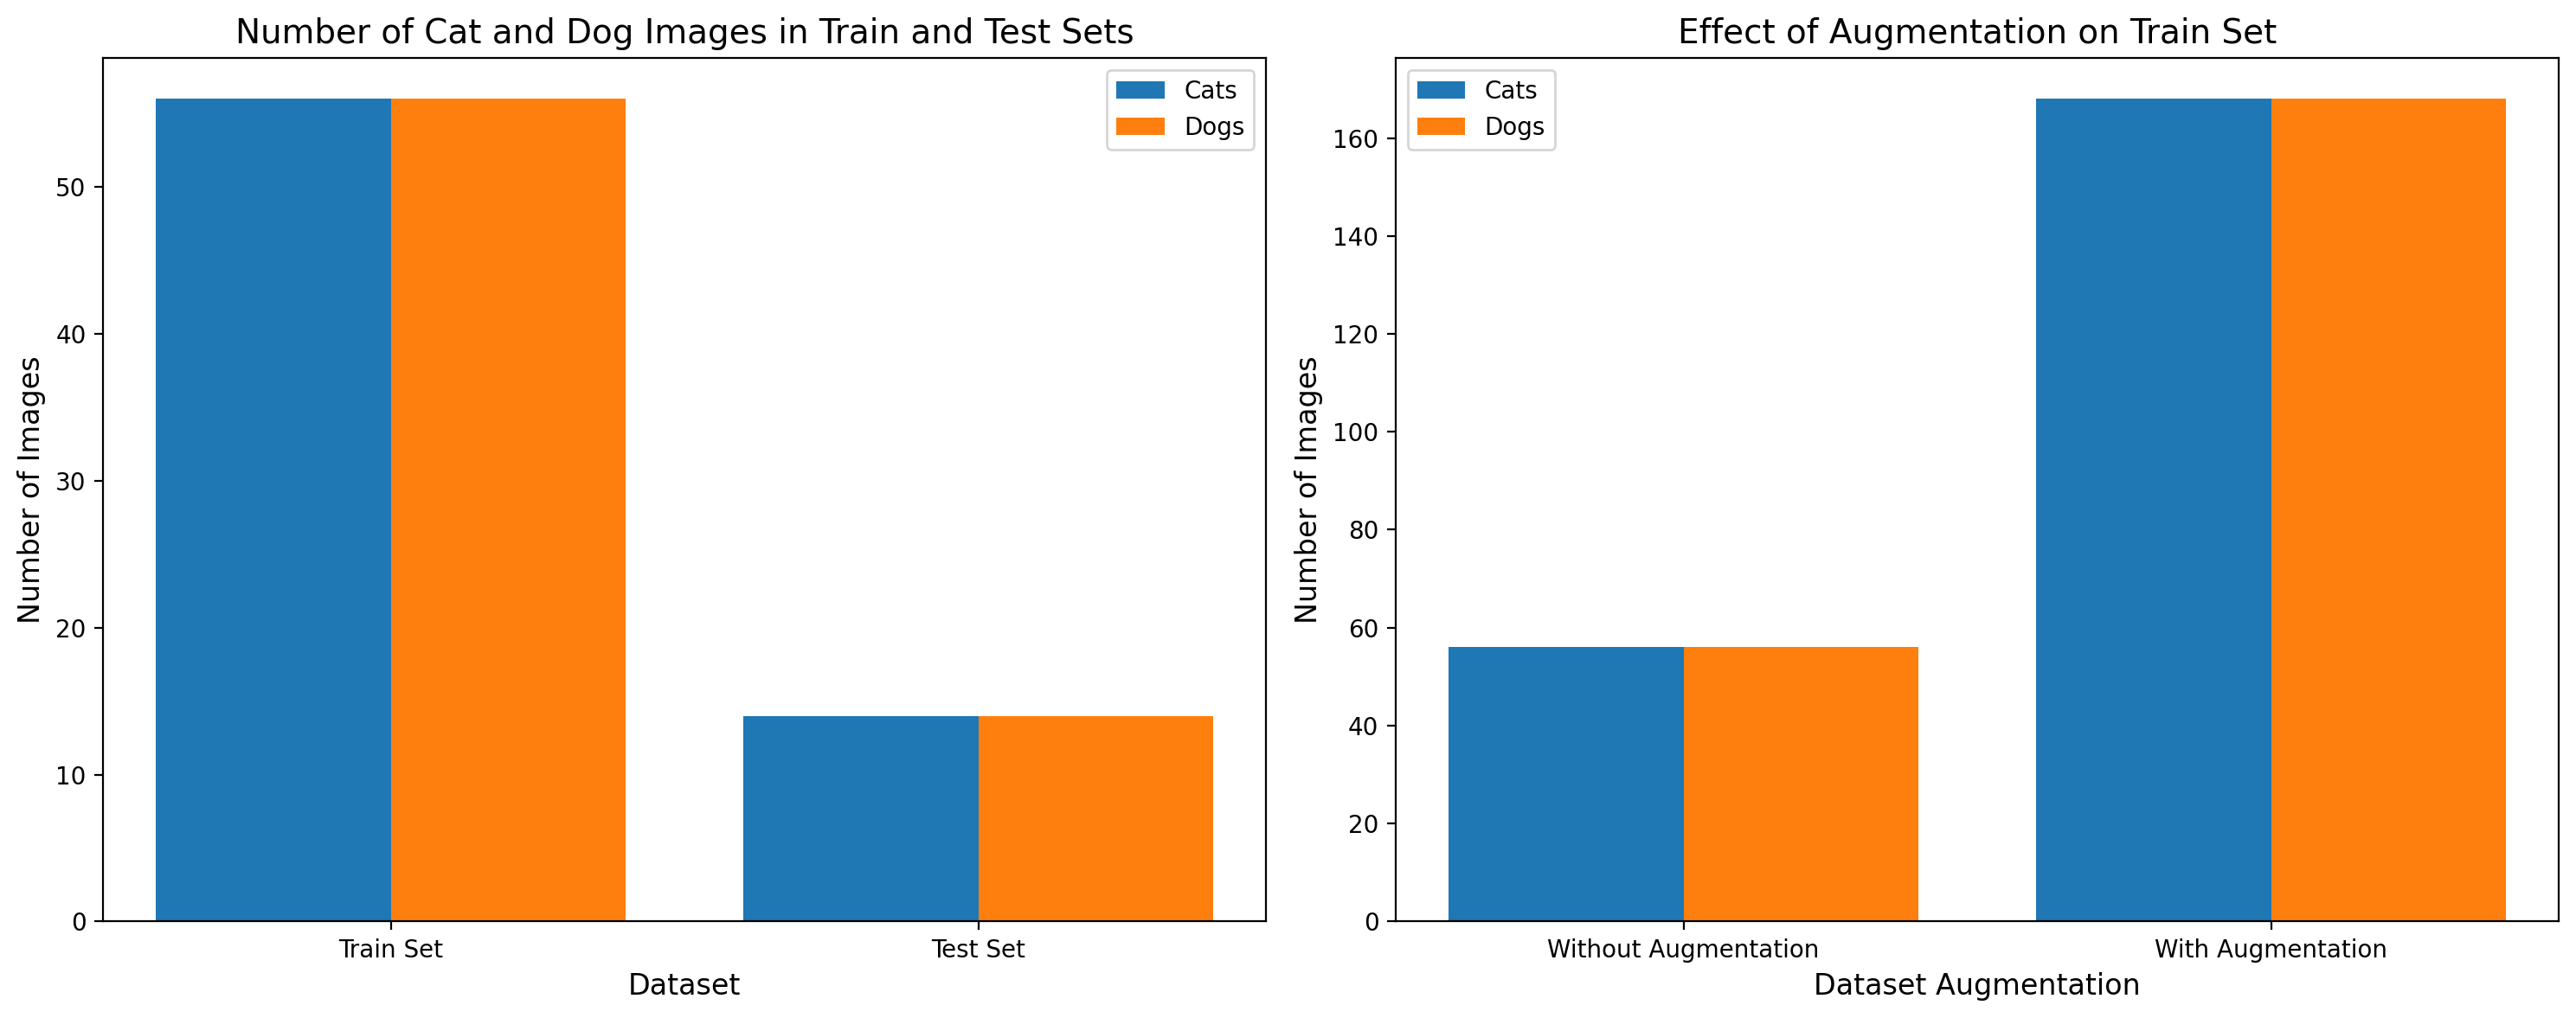

In [ ]:
categories = ['Train Set', 'Test Set', 'Augmented Train Set']

cat_counts = [
    len(os.listdir(os.path.join(dataset_path, "train/cats"))),
    len(os.listdir(os.path.join(dataset_path, "test/cats"))),
    len(os.listdir(os.path.join(dataset_path, "augmented/cats")))
]

dog_counts = [
    len(os.listdir(os.path.join(dataset_path, "train/dogs"))),
    len(os.listdir(os.path.join(dataset_path, "test/dogs"))),
    len(os.listdir(os.path.join(dataset_path, "augmented/dogs")))
]

x = np.arange(len(categories))

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(x[:2] - 0.2, cat_counts[:2], width=0.4, label='Cats')
plt.bar(x[:2] + 0.2, dog_counts[:2], width=0.4, label='Dogs')

plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Number of Cat and Dog Images in Train and Test Sets', fontsize=14)
plt.xticks(x[:2], categories[:2], fontsize=10)
plt.legend()

plt.subplot(1, 2, 2)

augmented_cat_count = cat_counts[2]
augmented_dog_count = dog_counts[2]
positions = [0, 1]
labels = ['Without Augmentation', 'With Augmentation']

plt.bar(
    np.array([positions[0] - 0.2, positions[1] - 0.2]),
    np.array([cat_counts[0], augmented_cat_count]),
    width=0.4,
    label='Cats')
plt.bar(
    np.array([positions[0] + 0.2, positions[1] + 0.2]),
    np.array([dog_counts[0], augmented_dog_count]),
    width=0.4,
    label='Dogs'
)

plt.xlabel('Dataset Augmentation', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Effect of Augmentation on Train Set', fontsize=14)
plt.xticks(positions, labels, fontsize=10)
plt.legend()

plt.tight_layout()
plt.show()


The dataset is balanced as the number of cats and the number of dogs in the train set, test set and the augmented set is equal

# Training the model

### Create Dataloader

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_dataset = datasets.ImageFolder(
    root = f"{dataset_path}/train",
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])
)
train_datset_aug = datasets.ImageFolder(
    root = f"{dataset_path}/augmented",
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])
)
test_dataset = datasets.ImageFolder(
    root=f"{dataset_path}/test",
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])
)
train_dataset_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
train_dataset_loader_aug = DataLoader(train_datset_aug, batch_size=32, shuffle=True)
test_dataset_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

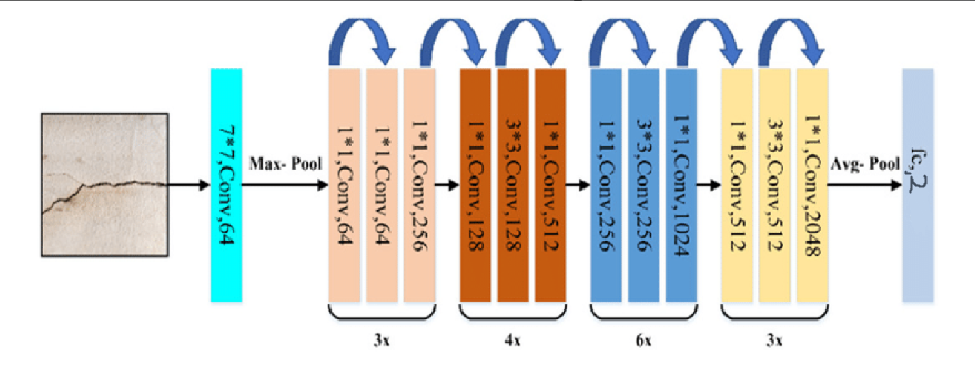

### Create two instances of the model

In [ ]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")
model_aug = copy.deepcopy(model)  # To get model with same parameters

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [32]:
print(f"The number of parameters in the resnet-50 model = {model.num_parameters()}")
print("Model:")
print(model)

The number of parameters in the resnet-50 model = 25557032
Model:
ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
              

### Calculating the metrics

In [14]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate accuracy, precision, recall, and F1-score.
    """
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    accuracy = (y_true == y_pred).sum().item() / len(y_true)

    num_classes = len(torch.unique(y_true))
    precision = []
    recall = []
    f1_score = []

    for c in range(num_classes):
        tp = ((y_pred == c) & (y_true == c)).sum().item()
        fp = ((y_pred == c) & (y_true != c)).sum().item()
        fn = ((y_pred != c) & (y_true == c)).sum().item()

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        precision.append(prec)
        recall.append(rec)
        f1_score.append(f1)

    # Take macro averages
    avg_precision = sum(precision) / num_classes
    avg_recall = sum(recall) / num_classes
    avg_f1_score = sum(f1_score) / num_classes

    return accuracy, avg_precision, avg_recall, avg_f1_score

### Train function

In [15]:
def train(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    model.train()
    train_metrics = []
    test_metrics = []

    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_accuracy, train_precision, train_recall, train_f1, _ = test(model, train_loader, criterion, device)
        test_accuracy, test_precision, test_recall, test_f1, test_loss = test(model, test_loader, criterion, device)

        train_metrics.append([train_accuracy, train_precision, train_recall, train_f1])
        test_metrics.append([test_accuracy, test_precision, test_recall, test_f1])

        print(f"Epoch {epoch+1}/{epochs}:\n"
              f"Train -> Acc: {train_accuracy:.4f}, Prec: {train_precision:.4f}, Rec: {train_recall:.4f}, F1: {train_f1:.4f}\n"
              f"Test  -> Acc: {test_accuracy:.4f}, Prec: {test_precision:.4f}, Rec: {test_recall:.4f}, F1: {test_f1:.4f}, Loss: {test_loss:.4f}")

    return train_metrics, test_metrics

### Test function

In [16]:
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    true_labels = []
    pred_labels = []
    total_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy, precision, recall, f1_score = calculate_metrics(true_labels, pred_labels)
    avg_loss = total_loss / len(test_loader)
    return accuracy, precision, recall, f1_score, avg_loss

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [18]:
train_metrics, test_metrics = train(model, train_dataset_loader, test_dataset_loader, optimizer, criterion, device, epochs=7)

train_metrics_aug, test_metrics_aug = train(model_aug, train_dataset_loader_aug, test_dataset_loader, optimizer_aug, criterion, device, epochs=7)

Epoch 1/7:
Train -> Acc: 0.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  -> Acc: 0.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, Loss: 10.5277
Epoch 2/7:
Train -> Acc: 0.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  -> Acc: 0.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, Loss: 8.6469
Epoch 3/7:
Train -> Acc: 0.0714, Prec: 0.7167, Rec: 0.0714, F1: 0.1298
Test  -> Acc: 0.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, Loss: 6.6430
Epoch 4/7:
Train -> Acc: 0.4732, Prec: 0.6870, Rec: 0.4732, F1: 0.5590
Test  -> Acc: 0.0714, Prec: 0.2000, Rec: 0.0714, F1: 0.1053, Loss: 3.8499
Epoch 5/7:
Train -> Acc: 0.6518, Prec: 0.6583, Rec: 0.6518, F1: 0.6540
Test  -> Acc: 0.4643, Prec: 0.5192, Rec: 0.4643, F1: 0.4900, Loss: 2.0157
Epoch 6/7:
Train -> Acc: 0.8036, Prec: 0.8099, Rec: 0.8036, F1: 0.8026
Test  -> Acc: 0.6429, Prec: 0.6761, Rec: 0.6429, F1: 0.6533, Loss: 1.4877
Epoch 7/7:
Train -> Acc: 0.9375, Prec: 0.9376, Rec: 0.9375, F1: 0.9375
Test  -> Acc: 0.6071, Prec: 0.6307, Rec: 0.6071, F1: 0.613

In [26]:
train_metrics = np.array(train_metrics)
test_metrics = np.array(test_metrics)
train_metrics_aug = np.array(train_metrics_aug)
test_metrics_aug = np.array(test_metrics_aug)

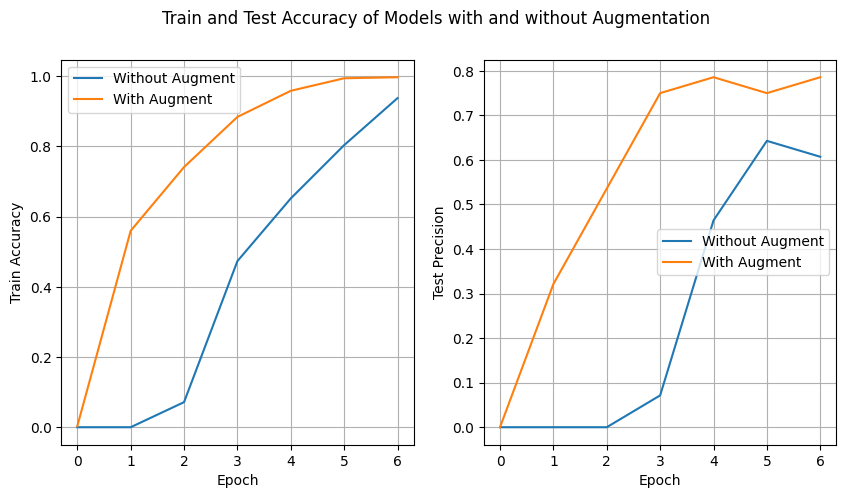

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_metrics[:, 0], label="Without Augment")
plt.plot(train_metrics_aug[:, 0], label="With Augment")
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy")
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(test_metrics[:, 0], label="Without Augment")
plt.plot(test_metrics_aug[:, 0], label="With Augment")
plt.xlabel("Epoch")
plt.ylabel("Test Precision")
plt.legend()
plt.grid()

plt.suptitle("Train and Test Accuracy of Models with and without Augmentation")
plt.show()

## Explanation of the results:

1. **Increased Data Variability**: Augmentation introduces variations (e.g., rotations, flips, brightness changes), helping the model generalize better to unseen data.  

2. **Reduction of Overfitting**: The model trained on non-augmented data might memorize patterns, while augmentation forces it to learn more robust features.  

3. **Better Feature Extraction**: Augmented data helps the model recognize objects under different conditions, improving its ability to extract meaningful features.  

4. **Improved Generalization**: Exposure to diverse transformations prevents the model from becoming biased to specific lighting, angles, or backgrounds.  

5. **More Effective Training**: Due to a small dataset, the number of images in the augmented train set is 3 times that in the train set. As the number of training images increased, the accuracies are tend to increase. 